## Initial Setup

This section:
- Installs required packages (`gspread` for Google Sheets access)
- Authenticates with Google Colab to access your Google Drive
- Defines constants for the Google Sheet IDs we'll be working with

In [ ]:
!pip install --upgrade gspread gspread_dataframe

In [ ]:
import gspread
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
INWARD_SHEET_ID = "1XQjHZSCPTMdrzLW06eiIm15iIjmurjn0dTFKDTbrdIg"
OUTWARD_SHEET_ID = "1bqx3rL_A_zm25YTxhGw4r5lE774x8jIs1ZwhskueXZQ"
PARTNER_SHEET_ID = "1uDLL_2-P2xJdXlVxZB1t_ktVnY5RINfYiRGSsM9QkHs"

## Country Data Standardization

Here we:
- Define a master list of standardized country names
- Identify our "Top 10" focus countries
- Create mapping dictionaries to handle sheet naming conventions
- Set up the sheet mapping structure that connects:
  - Inward FDI data
  - Outward FDI data
  - Partner country data

In [ ]:
master_country_list = sorted([
    "Albania", "Algeria", "Anguilla", "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan",
    "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bermuda",
    "Bhutan", "Bolivia", "Botswana", "Brazil", "British Indian Ocean Territory", "British Virgin Islands",
    "Brunei Darussalam", "Bulgaria", "Burkina Faso", "Cambodia", "Canada", "Cayman Island",
    "Channel Island", "Chile", "China", "Colombia", "Congo", "Cook Island", "Costa Rica", "Croatia", "Curacao",
    "Cyprus", "Czech Republic", "Denmark", "Djibouti", "Dominican Republic", "Ecuador", "Egypt", "Estonia",
    "Ethiopia", "Finland", "France", "Gabon", "Georgia", "Germany", "Ghana", "Gibraltar", "Greece", "Guam",
    "Guatemala", "Guernsey", "Guyana", "Honduras", "Hong Kong", "Hungary", "Iceland", "IFSC", "India",
    "Indonesia", "Iran", "Iraq", "Ireland", "Isle Of Man", "Israel", "Italy", "Japan",
    "Jersey", "Jordan", "Kazakhstan", "Kenya", "Kuwait", "Kyrgyz Republic",
    "Lao People's Democratic Republic", "Latvia", "Lebanon", "Liberia", "Libya", "Liechtenstein", "Lithuania",
    "Luxembourg", "Macau", "Macedonia", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall",
    "Mauritius", "Mexico", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar",
    "Namibia", "Nepal", "Netherland", "New Caledonia", "New Zealand", "Nigeria",
    "Northen Mariana Islands", "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
    "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Puerto Rico", "Qatar", "Romania", "Russia", "Rwanda",
    "Saint Vincent", "Samoa", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore",
    "Slovakia", "Slovenia", "Somalia", "South Africa", "South Korea", "Spain", "Sri Lanka", "State Of Palestine",
    "Sudan", "Swaziland", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Togo",
    "Trinidad & Tobago", "Tunisia", "Turkey", "Turks And Caicos Islands", "Uganda", "Ukraine",
    "United Arab Emirates", "United Kingdom", "United States", "United States Virgin Islands", "Uruguay",
    "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Zambia", "Zimbabwe"
])

In [ ]:
top_10 = [
    'Mauritius', 'Singapore', 'United States', 'Netherland',
    'Japan', 'United Kingdom', 'United Arab Emirates',
    'Cayman Island', 'Germany', 'Cyprus'
]

In [ ]:
country_sheet_map = {
    "Mauritius": "Mauritius",
    "Singapore": "Singapore",
    "United States": "USA",
    "Netherland": "Netherland",
    "Japan": "Japan",
    "United Kingdom": "UK",
    "United Arab Emirates": "UAE",
    "Cayman Island": "Cayman",
    "Germany": "Germany",
    "Cyprus": "Cyprus"
}

In [ ]:
iso_code_map = {
    "Albania" : "ALB", "Algeria" : "DZA", "Anguilla" : "AIA", "Argentina" : "ARG", "Armenia" : "ARM",
    "Australia" : "AUS", "Austria" : "AUT", "Azerbaijan" : "AZE", "Bahamas" : "BHS", "Bahrain" : "BHR",
    "Bangladesh" : "BGD", "Barbados" : "BRB", "Belarus" : "BLR", "Belgium" : "BEL", "Belize" : "BLZ",
    "Benin" : "BEN", "Bermuda" : "BMU", "Bhutan" : "BTN", "Bolivia" : "BOL", "Botswana" : "BWA",
    "Brazil" : "BRA", "British Indian Ocean Territory" : "IOT", "British Virgin Islands" : "VGB", "Brunei Darussalam" : "BRN",
    "Bulgaria" : "BGR", "Burkina Faso" : "BFA", "Cambodia" : "KHM", "Canada" : "CAN", "Cayman Island" : "CYM",
    "Channel Island" : "-", "Chile" : "CHL", "China" : "CHN", "Colombia" : "COL", "Congo" : "-",
    "Cook Island" : "COK", "Costa Rica" : "CRI", "Croatia" : "HRV", "Curacao" : "CUW", "Cyprus" : "CYP",
    "Czech Republic" : "CZE", "Denmark" : "DNK", "Djibouti" : "DJI", "Dominican Republic" : "DOM", "Ecuador" : "ECU",
    "Egypt" : "EGY", "Estonia" : "EST", "Ethiopia" : "ETH", "Finland" : "FIN", "France" : "FRA",
    "Gabon" : "GAB", "Georgia" : "GEO", "Germany" : "DEU", "Ghana" : "GHA", "Gibraltar" : "GIB",
    "Greece" : "GRC", "Guam" : "GUM", "Guatemala" : "GTM", "Guernsey" : "GGY", "Guyana" : "GIN",
    "Honduras" : "HND", "Hong Kong" : "HKG", "Hungary" : "HUN", "Iceland" : "ISL", "IFSC" : "-", "India" : "IND",
    "Indonesia" : "IDN", "Iran" : "IRN", "Iraq" : "IRQ", "Ireland" : "IRL", "Isle Of Man" : "INL",
    "Israel" : "ISR", "Italy" : "ITA", "Japan" : "JPN", "Jersey" : "JEY",
    "Jordan" : "JOR", "Kazakhstan" : "KAZ", "Kenya" : "KEN", "Kuwait" : "KWT", "Kyrgyz Republic" : "KGZ",
    "Lao People's Democratic Republic" : "LAO", "Latvia" : "LVA", "Lebanon" : "LBN", "Liberia" : "LBR",
    "Libya" : "LBY", "Liechtenstein" : "LIE", "Lithuania" : "LTU", "Luxembourg" : "LUX", "Macau" : "MAC",
    "Macedonia" : "MKD", "Madagascar" : "MDG", "Malawi" : "MWI", "Malaysia" : "MYS", "Maldives" : "MDV",
    "Mali" : "MLI", "Malta" : "MLT", "Marshall" : "MHL", "Mauritius" : "MUS", "Mexico" : "MEX",
    "Moldova" : "MDA", "Monaco" : "MCO", "Mongolia" : "MNG", "Montenegro" : "MNE", "Morocco" : "MAR",
    "Mozambique" : "MOZ", "Myanmar" : "MMR", "Namibia" : "NAM", "Nepal" : "NPL", "Netherland" : "NLD",
    "New Caledonia" : "NCL", "New Zealand" : "NZL", "Nigeria" : "NGA", "Northen Mariana Islands" : "MNP", "Norway" : "NOR",
    "Oman" : "OMN", "Pakistan" : "PAK", "Palau" : "PLW", "Panama" : "PAN", "Papua New Guinea" : "PNG",
    "Paraguay" : "PRY", "Peru" : "PER", "Philippines" : "PHL", "Poland" : "POL", "Portugal" : "PRT",
    "Puerto Rico" : "PRI", "Qatar" : "QAT", "Romania" : "ROU", "Russia" : "RUS", "Rwanda" : "RWA",
    "Saint Vincent" : "VCT", "Samoa" : "WSM", "Saudi Arabia" : "SAU", "Senegal" : "SEN", "Serbia" : "SRB",
    "Seychelles" : "SYC", "Sierra Leone" : "SLE", "Singapore" : "SGP", "Slovakia" : "SVK", "Slovenia" : "SVN",
    "Somalia" : "SOM", "South Africa" : "ZAF", "South Korea" : "KOR", "Spain" : "ESP", "Sri Lanka" : "LKA",
    "State Of Palestine" : "PSE", "Sudan" : "SDN", "Swaziland" : "SWZ", "Sweden" : "SWE", "Switzerland" : "CHE",
    "Syria" : "SYR", "Taiwan" : "TWN", "Tajikistan" : "TJK", "Tanzania" : "TZA", "Thailand" : "THA",
    "Togo" : "TGO", "Trinidad & Tobago" : "TTO", "Tunisia" : "TUN", "Turkey" : "TUR", "Turks And Caicos Islands" : "TCA",
    "Uganda" : "UGA", "Ukraine" : "UKR", "United Arab Emirates" : "ARE", "United Kingdom" : "GBR", "United States" : "USA",
    "United States Virgin Islands" : "VIR", "Uruguay" : "URY", "Uzbekistan" : "UZB",
    "Vanuatu" : "VUT", "Venezuela" : "VEN", "Vietnam" : "VNM", "Zambia" : "ZMB", "Zimbabwe" : "ZWE"
}

In [ ]:
valid_partners = [c for c in top_10 if c not in ['United Arab Emirates', 'Cayman Island']]

sheet_map = {
    INWARD_SHEET_ID: ['FDI_2023_Total'],
    OUTWARD_SHEET_ID: ['OFDI_2023_Total'],
    PARTNER_SHEET_ID: [
        f"{country_sheet_map[c]}_Inward" for c in valid_partners
    ] + [
        f"{country_sheet_map[c]}_Outward" for c in valid_partners
    ]
}

## Data Cleaning and ISO Code Augmentation

This phase prepares each worksheet for accurate downstream analysis by:

### Data Cleaning

1. Extracting raw data from Google Sheets
2. Standardizing country names (matching against a master list)
3. Cleaning numeric values (removing commas, converting to floats)
4. Adding any missing countries with a default value of zero
5. Sorting the dataset alphabetically by country
6. Writing the cleaned data back to the sheet

Robust error handling ensures that processing continues even if some sheets are malformed or empty.

### ISO Country Code Integration

1. Appending ISO codes as a new column (`ISO_Code`)
2. Reordering columns to `[ISO_Code, Country, Value]`
3. Handling edge cases where names differ from official country formats

> Countries without a recognized ISO match are assigned `'NA'`, but their original names are retained for reference.


In [ ]:
import re
import pandas as pd
from gspread_dataframe import set_with_dataframe

In [ ]:
def get_iso_code(country_name):
    return iso_code_map.get(country_name, '-')

# Main processing
for sheet_id, sheet_names in sheet_map.items():
    gsheet = gc.open_by_key(sheet_id)

    for name in sheet_names:
        try:
            print(f"Processing sheet: {name}")
            ws = gsheet.worksheet(name)
            raw = ws.get_all_values()
            df = pd.DataFrame(raw)

            if df.empty or df.shape[1] < 2:
                print(f"Sheet {name} is empty or malformed.")
                continue

            # Normalize headers
            df.columns = df.iloc[0]
            df = df.drop(index=0).reset_index(drop=True)

            # Check if already normalized
            cols = [col.strip() for col in df.columns.tolist()]
            already_normalized = set(cols[:3]) == {'ISO_Code', 'Country', 'Value'}

            if not already_normalized:
                df = pd.DataFrame(raw)
                df = df.iloc[:, :2]
                df.columns = ['Country', 'Value']
                df = df.dropna().copy()
                df['Country'] = df['Country'].str.strip()
                df['Value'] = df['Value'].str.replace(",", "").str.strip()
                df = df[df['Value'].apply(lambda x: bool(re.match(r'^-?\d+(\.\d+)?$', x)))]
                df['Value'] = pd.to_numeric(df['Value'])
                df['Country'] = df['Country'].str.title()

                def standardize(country):
                    matches = [m for m in master_country_list if m.lower() == country.lower()]
                    return matches[0] if matches else country
                df['Country'] = df['Country'].apply(standardize)

                current_countries = set(df['Country'])
                missing = [c for c in master_country_list if c not in current_countries]
                missing_df = pd.DataFrame({'Country': missing, 'Value': 0})
                df = pd.concat([df, missing_df], ignore_index=True)
                df = df.sort_values(by='Country').reset_index(drop=True)

                df['ISO_Code'] = df['Country'].apply(get_iso_code)
                df = df[['ISO_Code', 'Country', 'Value']]
                print(f"Normalized and ISO-coded: {name}")
            else:
                df['Country'] = df['Country'].str.strip().str.title()
                df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0)

                if 'ISO_Code' not in df.columns:
                    df['ISO_Code'] = df['Country'].apply(get_iso_code)

                df = df[['ISO_Code', 'Country', 'Value']]
                print(f"Already normalized. Cleaned: {name}")

            ws.clear()
            set_with_dataframe(ws, df)

        except Exception as e:
            print(f"Failed: {name} - {e}")

In [ ]:
# Utility
def get_iso_code(country_name):
    return iso_code_map.get(country_name, '-')

def standardize(country):
    matches = [m for m in master_country_list if m.lower() == country.lower()]
    return matches[0] if matches else country

EXCLUDED_SHEETS = {'FDI_2023_Total', 'OFDI_2023_Total'}

# Main Processing
for sheet_id, sheet_names in sheet_map.items():
    gsheet = gc.open_by_key(sheet_id)

    for name in sheet_names:
        if name in EXCLUDED_SHEETS:
            print(f"Skipping excluded sheet: {name}")
            continue

        try:
            print(f"Processing sheet: {name}")
            ws = gsheet.worksheet(name)
            raw = ws.get_all_values()
            df = pd.DataFrame(raw)

            if df.empty or df.shape[1] < 2:
                print(f"Sheet {name} is empty or malformed.")
                continue

            # Normalize headers
            df.columns = df.iloc[0]
            df = df.drop(index=0).reset_index(drop=True)
            cols = [col.strip() for col in df.columns.tolist()]
            already_normalized = set(cols[:3]) == {'ISO_Code', 'Country', 'Value'}

            if not already_normalized:
                df = pd.DataFrame(raw).iloc[:, :2]
                df.columns = ['Country', 'Value']
                df = df.dropna(subset=['Country', 'Value']).copy()
                df['Country'] = df['Country'].str.strip().str.title()
                df['Value'] = (
                    df['Value']
                    .str.replace(",", "", regex=False)
                    .str.strip()
                )

                df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
                df = df.dropna(subset=['Value'])

                df['Country'] = df['Country'].apply(standardize)

                current_countries = set(df['Country'])
                missing = [c for c in master_country_list if c not in current_countries]
                missing_df = pd.DataFrame({'Country': missing, 'Value': 0})
                df = pd.concat([df, missing_df], ignore_index=True)
                df = df.sort_values(by='Country').reset_index(drop=True)

                df['ISO_Code'] = df['Country'].apply(get_iso_code)
                df = df[['ISO_Code', 'Country', 'Value']]
                print(f"Normalized and ISO-coded: {name}")

            else:
                df['Country'] = df['Country'].str.strip().str.title()
                df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0)

                if 'ISO_Code' not in df.columns:
                    df['ISO_Code'] = df['Country'].apply(get_iso_code)

                df = df[['ISO_Code', 'Country', 'Value']]
                print(f"Already normalized. Cleaned: {name}")

            df['Value'] = df['Value'].round(4)

            ws.clear()
            set_with_dataframe(ws, df)

        except Exception as e:
            print(f"Failed: {name} - {e}")

## Top 10 Country Focus

This section creates specialized worksheets focusing exclusively on:
- India's **top 10 inward FDI partners** (sources of foreign investment into India)
- India's **top 10 outward FDI destinations** (where Indian companies invest abroad)

**Data Source**:
These top 10 lists are derived from the [DPIIT Fact Sheet (October-December 2023)](https://dpiit.gov.in/sites/default/files/Fact%20Sheet%20December%202023_1.pdf), which identifies the following **Inward Top 10**:
   - Mauritius (27% of total FDI equity inflows)
   - Singapore (16%)
   - USA (9%)
   - Netherlands (7%)
   - Japan (6%)
   - UK (5%)
   - UAE (4%)
   - Cayman Islands (3%)
   - Germany (2%)
   - Cyprus (2%)

**Purpose**:
- Simplifies analysis of India's most significant economic relationships
- Preserves full datasets while enabling focused examination
- Maintains consistency with official government reporting

In [ ]:
import pandas as pd
def delete_sheet_if_exists(gsheet, title):
    try:
        worksheet = gsheet.worksheet(title)
        gsheet.del_worksheet(worksheet)
        print(f"Deleted existing sheet: {title}")
    except gspread.exceptions.WorksheetNotFound:
        print(f"No existing sheet named '{title}' to delete.")
def extract_top_10(source_ws_title, target_ws_title, gsheet_id):
    try:
        gsheet = gc.open_by_key(gsheet_id)
        delete_sheet_if_exists(gsheet, target_ws_title)
        ws = gsheet.worksheet(source_ws_title)
        raw = ws.get_all_values()
        df = pd.DataFrame(raw)
        if df.empty or df.shape[1] < 2:
            print(f"Sheet {source_ws_title} is empty or malformed.")
            return
        df.columns = df.iloc[0]
        df = df.drop(index=0).reset_index(drop=True)

        if 'Country' not in df.columns or 'Value' not in df.columns:
            print(f"Sheet {source_ws_title} missing required columns.")
            return

        df['Country'] = df['Country'].str.strip().str.title()
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0)

        filtered_df = df[df['Country'].isin(top_10)].copy()
        filtered_df = filtered_df[['Country', 'Value']].sort_values(by='Country').reset_index(drop=True)

        new_ws = gsheet.add_worksheet(title=target_ws_title, rows=100, cols=3)
        set_with_dataframe(new_ws, filtered_df)
        print(f"Created '{target_ws_title}' with top 10 data.")

    except Exception as e:
        print(f"Failed processing '{source_ws_title}' → '{target_ws_title}': {e}")

extract_top_10(
    source_ws_title='FDI_2023_Total',
    target_ws_title='Top_10_Inward',
    gsheet_id=INWARD_SHEET_ID
)

extract_top_10(
    source_ws_title='OFDI_2023_Total',
    target_ws_title='Top_10_Outward',
    gsheet_id=OUTWARD_SHEET_ID
)


## Bilateral Partner Identification Logic for the Top 3 Partners for each of the Top 10 Partners of India

### Mathematical Framework

For each focus country **i** (from our Top 10 list), we:

1. **Bilateral Flow Calculation**:
   - Let:
     - `FDIin_{j→i}` = Inward FDI to country *i* from partner *j*
     - `FDIout_{i→j}` = Outward FDI from country *i* to partner *j*
   - Compute total bilateral engagement:  
     ```
     W_ij = |FDIin_{j→i}| + |FDIout_{i→j}|
     ```
   - Absolute values ensure we consider economic volume regardless of directionality

2. **Partner Ranking**:
   - For each *i*, sort all partners *j* by `W_ij` in descending order
   - Select top 3 partners where:
     ```
     Top3(i) = argmax(j,3) W_ij
     ```
   - Excludes self-loops (where *i* = *j*)

3. **Network Construction**:
   - Creates directed edges with weights:
     - `i → j`: φ_ij = 1/W_ij (proximity metric)
     - `j → i`: φ_ji = 1/W_ji

### Theoretical Justification

1. **Economic Interpretation**:
   - `W_ij` captures total cross-border capital flow
   - Reciprocal (1/W) transformation converts volume to distance metric  
     (larger flows → smaller distances)

2. **Graph Theory Basis**:
   - Forms a directed, weighted network amenable to:
     - Community detection
     - Centrality analysis
     - Minimum spanning tree derivation

3. **Top-3 Selection Rationale**:
   - Maintains network sparsity while preserving key economic relationships

### Implementation Notes
- Handles missing data via zero-filling (no flow = zero weight)
- Uses dictionary-based accumulation for O(n) partner aggregation
- Normalizes country names using master list before processing

In [ ]:
from collections import defaultdict

valid_partners = [c for c in top_10 if c not in ['United Arab Emirates', 'Cayman Island']]
top_3_partners = {}

for country in valid_partners:
    short = country_sheet_map[country]
    try:
        print(f"\nProcessing {country}...")
        inward_ws = gc.open_by_key(PARTNER_SHEET_ID).worksheet(f"{short}_Inward")
        outward_ws = gc.open_by_key(PARTNER_SHEET_ID).worksheet(f"{short}_Outward")

        inward_df = pd.DataFrame(inward_ws.get_all_records())
        outward_df = pd.DataFrame(outward_ws.get_all_records())
        for df in [inward_df, outward_df]:
            df['Country'] = df['Country'].astype(str).str.strip().str.title()
            df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0)

        #Compute FDI_in[j → i]
        fdi_in = inward_df.groupby('Country')['Value'].sum().to_dict()

        #Compute FDI_out[i → j]
        fdi_out = outward_df.groupby('Country')['Value'].sum().to_dict()

        #Calculate bilateral flow W[i][j] = |FDI_in[j→i]| + |FDI_out[i→j]|
        bilateral_fdi = defaultdict(float)

        for partner, val in fdi_in.items():
            if partner != country:
                bilateral_fdi[partner] += abs(val)
        for partner, val in fdi_out.items():
            if partner != country:
                bilateral_fdi[partner] += abs(val)
        sorted_partners = sorted(bilateral_fdi.items(), key=lambda x: x[1], reverse=True)
        top_3 = [partner for partner, _ in sorted_partners[:3]]
        top_3_partners[country] = top_3

    except Exception as e:
        print(f"Failed processing {country}: {e}")
print("\nTop 3 Bilateral FDI Partners for Each Country:")
for country, partners in top_3_partners.items():
    print(f"{country}: {partners}")


In [ ]:
india_outward_df = pd.DataFrame(
    gc.open_by_key(OUTWARD_SHEET_ID).worksheet('Top_10_Outward').get_all_records()
)
india_inward_df = pd.DataFrame(
    gc.open_by_key(INWARD_SHEET_ID).worksheet('Top_10_Inward').get_all_records()
)

india_outward_df['Value'] = pd.to_numeric(india_outward_df['Value'], errors='coerce').fillna(0)
india_inward_df['Value'] = pd.to_numeric(india_inward_df['Value'], errors='coerce').fillna(0)

In [ ]:
partner_links = []
for country, partners in top_3_partners.items():
    short = country_sheet_map[country]

    inward_df = pd.DataFrame(
        gc.open_by_key(PARTNER_SHEET_ID).worksheet(f"{short}_Inward").get_all_records()
    )
    outward_df = pd.DataFrame(
        gc.open_by_key(PARTNER_SHEET_ID).worksheet(f"{short}_Outward").get_all_records()
    )

    for df in [inward_df, outward_df]:
        df['Country'] = df['Country'].astype(str).str.strip().str.title()
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0)

    #Edges: j → country
    for _, row in inward_df.iterrows():
        if row['Country'] != country:
            partner_links.append((row['Country'], country, abs(row['Value'])))
    #Edges: country → j
    for _, row in outward_df.iterrows():
        if row['Country'] != country:
            partner_links.append((country, row['Country'], abs(row['Value'])))

partner_df = pd.DataFrame(partner_links, columns=['source', 'target', 'value'])

## Proximity Matrix Construction: Mathematical Foundations

### Core Concept
We transform raw FDI flows into a *distance-weighted adjacency matrix* that encodes the economic closeness between countries. This serves as the mathematical backbone for all subsequent network analysis.

### Mathematical Formulation

1. **Node Set Definition**:
   ```
   V = {India} ∪ {Top 10 Countries} ∪ {Their Top 3 Partners}
   ```
   - Represents all economic entities in our network
   - Ensures we capture both direct and indirect relationships

2. **Flow Matrix (F)**:
   For each ordered pair (i,j):
   ```
   f_ij = {
       FDI from i→j if data exists,
       0 otherwise
   }
   ```
   - Directionality matters (f_ij ≠ f_ji in most cases)
   - Contains raw monetary values (USD million)

3. **Proximity Matrix (Φ)**:
   ```
   Φ_ij = 1/(|f_ij| + |f_ji| + ε)
   ```
   Where:
   - ε = small constant ($1 \times 10^{-6}$) to prevent division by zero
   - |f_ij| = absolute value of directed flow

### Theoretical Justification

1. **Why Reciprocal Transformation?**
   - Converts *flow magnitudes* into *economic distances*:
     - High FDI → Small Φ (close proximity)
     - Low FDI → Large Φ (distant relationship)
   - Mathematically ensures:
     - Φ_ij > 0 ∀ i,j (non-negativity)
     - Φ_ij = Φ_ji (symmetry)

2. **Why Sum Both Directions?**
   - Captures *total bilateral engagement* between pairs
   - Accounts for both:
     - Investments from i→j (outward)
     - Investments from j→i (inward)
   - More robust than unidirectional measures

3. **Network Theory Interpretation**
   The matrix Φ defines a metric space where:
   - Nodes = Countries
   - Edge weights = Economic proximity (1/Φ = flow intensity)
   - Forms a complete digraph that we later prune

### Practical Advantages

1. **Normalization**:
   - Brings all values to comparable scale (0,1]
   - Reduces sensitivity to absolute flow magnitudes

2. **Distance Properties**:
   - Satisfies key metric conditions:
     - Φ_ij = 0 ⇔ i = j (identity)
     - Φ_ij = Φ_ji (symmetry)
     - Φ_ik ≤ Φ_ij + Φ_jk (triangle inequality)

3. **Analytical Benefits**:
   - Enables direct application of:
     - Shortest path algorithms (Dijkstra's)
     - Community detection (modularity maximization)
     - Centrality measures (eigenvector centrality)

### Implementation Notes
- Stored as pandas DataFrame for easy manipulation
- Diagonal forced to 0 (Φ_ii = 0 ∀ i)
- Missing pairs assigned Φ = ∞ (effectively no connection)

In [ ]:
import pandas as pd
import numpy as np

#India + Top 10 + their Top 3s
nodes = set(['India'] + top_10)
for partners in top_3_partners.values():
    nodes.update(partners)
nodes = sorted(nodes)
f_ij = {}

# India → Top 10
for _, row in india_outward_df.iterrows():
    u, v, w = 'India', row['Country'].strip().title(), abs(row['Value'])
    if u != v and v in nodes:
        f_ij[(u, v)] = w

# Top 10 → India
for _, row in india_inward_df.iterrows():
    u, v, w = row['Country'].strip().title(), 'India', abs(row['Value'])
    if u != v and u in nodes:
        f_ij[(u, v)] = w

# Partner edges (Top 10 ↔ Top 3)
for _, row in partner_df.iterrows():
    u = row['source'].strip().title()
    v = row['target'].strip().title()
    w = abs(row['value'])
    if u != v and u in nodes and v in nodes:
        f_ij[(u, v)] = f_ij.get((u, v), 0) + w

#Construct symmetric proximity matrix Φᵢⱼ
phi = pd.DataFrame(np.inf, index=nodes, columns=nodes)

for i in nodes:
    for j in nodes:
        if i == j:
            phi.at[i, j] = 0
        else:
            fij = f_ij.get((i, j), 0)
            fji = f_ij.get((j, i), 0)
            total = fij + fji
            phi.at[i, j] = 1 / total if total > 0 else np.inf

display(phi)

,Australia,Bermuda,Canada,Cayman Island,China,Cyprus,France,Germany,India,Ireland,Japan,Luxembourg,Mauritius,Netherland,Russia,Singapore,Switzerland,United Arab Emirates,United Kingdom,United States
Australia,0.000000,inf,inf,inf,inf,0.040258,inf,0.036928,inf,inf,0.006051,inf,inf,0.000081,inf,0.000018,inf,inf,0.000980,0.000048
Bermuda,inf,0.000000,inf,inf,inf,0.000149,inf,0.000498,inf,inf,0.037601,inf,inf,inf,inf,inf,inf,inf,0.001075,0.000029
Canada,inf,inf,0.000000,inf,inf,inf,inf,0.000526,inf,inf,0.022195,inf,inf,0.000088,inf,0.000192,inf,inf,0.000183,0.000011
Cayman Island,inf,inf,inf,0.000000,inf,inf,inf,0.001085,0.003411,inf,0.034570,inf,inf,inf,inf,inf,inf,inf,inf,inf
China,inf,inf,inf,inf,0.000000,0.011574,inf,0.000549,inf,inf,0.037461,inf,0.172117,0.000168,inf,0.000006,inf,inf,0.000234,0.000133
Cyprus,0.040258,0.000149,inf,inf,0.011574,0.000000,0.066138,0.001052,0.118692,inf,1.209044,0.000070,inf,0.000516,0.000038,0.016534,0.154321,0.006859,0.000246,inf
France,inf,inf,inf,inf,inf,0.066138,0.000000,0.000076,inf,inf,0.025963,inf,0.006475,0.000039,inf,0.001263,inf,inf,0.000042,0.000058
Germany,0.036928,0.000498,0.000526,0.001085,0.000549,0.001052,0.000076,0.000000,0.004844,0.000060,0.000724,0.000096,0.007889,0.000029,0.000994,0.000121,0.000079,0.003054,0.000019,0.000014
India,inf,inf,inf,0.003411,inf,0.118692,inf,0.004844,0.000000,inf,0.005256,inf,0.014603,0.000572,inf,0.000011,inf,0.003177,0.000819,0.000109
Ireland,inf,inf,inf,inf,inf,inf,inf,0.000060,inf,0.000000,0.012235,inf,inf,0.000097,inf,0.000140,inf,inf,inf,0.000022


## Network Pruning: Advanced Thresholding Methodologies

### Core Objective
Transform the complete weighted digraph into a sparse, analytically tractable network while preserving economically significant relationships.

---

### 1. Absolute Threshold Method
**Mathematical Formulation**:
```python
G_pruned = {(i,j) ∈ E | (f_ij + f_ji) ≥ τ_abs}
```
Where:
- τ_abs = Absolute cutoff value (e.g., $10M USD)
- f_ij = Directed flow from i→j

**Economic Rationale**:
- Removes statistically insignificant flows
- Maintains only relationships exceeding minimum economic impact
- Particularly useful when analyzing specific investment thresholds

**Trade-offs**: <br>
✓ Simple to implement and interpret<br>
✖ Doesn't account for relative importance of flows<br>
✖ May disproportionately affect smaller economies

---

### 2. Percentile Threshold (Current Approach)
**Implementation**:
1. Compute all bilateral flow magnitudes:
   ```python
   W = [|f_ij| + |f_ji| for (i,j) in E]
   ```
2. Determine cutoff at 75th percentile:
   ```python
   τ_perc = np.percentile(W, 75)
   ```
3. Retain edges where:
   ```python
   (f_ij + f_ji) ≥ τ_perc
   ```

**Why 75th Percentile?**
- Balances network sparsity with information retention
- Focuses analysis on the most economically significant quartile
- Adapts to the actual flow distribution in the data

**Statistical Properties**:
- Preserves approximately 25% of edges
- Automatically adjusts to data scale

---

### 3. Degree-Constrained Threshold
**Algorithm**:
```python
for each node i:
    sort neighbors j by W_ij descending
    keep top k edges where k = min(degree_cap, degree(i))
```

**Key Parameters**:
- degree_cap = Maximum allowed connections (e.g., 5)
- W_ij = Total flow between i and j

**Advantages**:<br>
✓ Mimics real-world limited attention in economic networks<br>
✓ Naturally highlights hub-and-spoke structures<br>
✓ Computationally efficient for large networks

**Use Case Example**:
When modeling information flow where countries have limited capacity to maintain numerous strong partnerships.

---

### 4. Density-Targeted Pruning
**Mathematical Formulation**:
```python
target_edges = ρ * n(n-1)  # ρ = desired density
sort all edges by W_ij descending
keep top target_edges
```

**Typical Density Values**:
- ρ ≈ 0.15 for small-world networks
- ρ ≈ 0.05 for hierarchical structures

---

### Comparative Analysis

| Method          | Complexity | Data-Driven | Economic Interpretation |
|-----------------|------------|-------------|--------------------------|
| Absolute        | O(1)       | No          | Clear monetary threshold |
| Percentile      | O(n log n) | Yes         | Relative significance    |
| Degree          | O(n²)      | Partial     | Attention constraints    |
| Density         | O(n²)      | Yes         | Topological control      |

**Why Percentile Threshold Prevails**:
1. **Adaptability**: Automatically scales with data
2. **Robustness**: Less sensitive to outliers than absolute thresholds
3. **Interpretability**: Clearly identifies "top tier" relationships
4. **Theoretical Support**: Aligns with heavy-tailed distributions common in economic networks

**Implementation Caveats**:
- Requires recomputation if underlying data changes
- May need adjustment for very heterogeneous datasets
- Edge removal can affect centrality measures

In [ ]:
# Option 1: Absolute Threshold
def apply_absolute_threshold(phi_matrix, f_ij, threshold_value):
    phi_filtered = phi_matrix.copy()
    for i in phi_matrix.index:
        for j in phi_matrix.columns:
            if i != j:
                fij = f_ij.get((i, j), 0)
                fji = f_ij.get((j, i), 0)
                total = fij + fji
                if total < threshold_value:
                    phi_filtered.at[i, j] = np.inf
    return phi_filtered

# Option 2: Percentile Threshold
def apply_percentile_threshold(phi_matrix, f_ij, percentile=70):
    values = []
    for (i, j), val in f_ij.items():
        if (j, i) in f_ij:
            total = val + f_ij[(j, i)]
            if i < j:
                values.append(total)
    values = sorted(values, reverse=True)
    cutoff = np.percentile(values, 100 - percentile)
    phi_filtered = phi_matrix.copy()
    for i in phi_matrix.index:
        for j in phi_matrix.columns:
            if i != j:
                fij = f_ij.get((i, j), 0)
                fji = f_ij.get((j, i), 0)
                total = fij + fji
                if total < cutoff:
                    phi_filtered.at[i, j] = np.inf
    return phi_filtered

# Option 3: Degree-based Threshold
def apply_degree_threshold(phi_matrix, max_degree=5):
    phi_filtered = phi_matrix.copy()
    for node in phi_filtered.index:
        neighbors = phi_filtered.loc[node].copy()
        neighbors = neighbors[neighbors != 0].sort_values()
        top_k = neighbors.iloc[:max_degree]
        for neighbor in phi_filtered.columns:
            if neighbor not in top_k.index and node != neighbor:
                phi_filtered.at[node, neighbor] = np.inf
    return phi_filtered

# Option 4: Network Density Threshold
def apply_density_threshold(phi_matrix, target_density=0.2):
    N = len(phi_matrix)
    max_edges = N * (N - 1) // 2
    target_edges = int(target_density * max_edges)

    entries = []
    for i in phi_matrix.index:
        for j in phi_matrix.columns:
            if i < j and phi_matrix.at[i, j] < np.inf:
                fij = f_ij.get((i, j), 0)
                fji = f_ij.get((j, i), 0)
                total = fij + fji
                entries.append((i, j, total))

    entries = sorted(entries, key=lambda x: -x[2])
    selected = entries[:target_edges]

    selected_pairs = {(i, j) for i, j, _ in selected}
    phi_filtered = pd.DataFrame(np.inf, index=phi_matrix.index, columns=phi_matrix.columns)
    for i in phi_matrix.index:
        for j in phi_matrix.columns:
            if i == j:
                phi_filtered.at[i, j] = 0
            elif (i, j) in selected_pairs or (j, i) in selected_pairs:
                phi_filtered.at[i, j] = phi_matrix.at[i, j]

    return phi_filtered

In [ ]:
phi_percentile = apply_percentile_threshold(phi, f_ij, percentile=75)
display(phi_percentile)

,Australia,Bermuda,Canada,Cayman Island,China,Cyprus,France,Germany,India,Ireland,Japan,Luxembourg,Mauritius,Netherland,Russia,Singapore,Switzerland,United Arab Emirates,United Kingdom,United States
Australia,0.000000,inf,inf,inf,inf,0.040258,inf,0.036928,inf,inf,0.006051,inf,inf,0.000081,inf,0.000018,inf,inf,0.000980,0.000048
Bermuda,inf,0.000000,inf,inf,inf,0.000149,inf,0.000498,inf,inf,0.037601,inf,inf,inf,inf,inf,inf,inf,0.001075,0.000029
Canada,inf,inf,0.000000,inf,inf,inf,inf,0.000526,inf,inf,0.022195,inf,inf,0.000088,inf,0.000192,inf,inf,0.000183,0.000011
Cayman Island,inf,inf,inf,0.000000,inf,inf,inf,0.001085,0.003411,inf,0.034570,inf,inf,inf,inf,inf,inf,inf,inf,inf
China,inf,inf,inf,inf,0.000000,0.011574,inf,0.000549,inf,inf,0.037461,inf,inf,0.000168,inf,0.000006,inf,inf,0.000234,0.000133
Cyprus,0.040258,0.000149,inf,inf,0.011574,0.000000,0.066138,0.001052,inf,inf,inf,0.000070,inf,0.000516,0.000038,0.016534,inf,0.006859,0.000246,inf
France,inf,inf,inf,inf,inf,0.066138,0.000000,0.000076,inf,inf,0.025963,inf,0.006475,0.000039,inf,0.001263,inf,inf,0.000042,0.000058
Germany,0.036928,0.000498,0.000526,0.001085,0.000549,0.001052,0.000076,0.000000,0.004844,0.000060,0.000724,0.000096,0.007889,0.000029,0.000994,0.000121,0.000079,0.003054,0.000019,0.000014
India,inf,inf,inf,0.003411,inf,inf,inf,0.004844,0.000000,inf,0.005256,inf,0.014603,0.000572,inf,0.000011,inf,0.003177,0.000819,0.000109
Ireland,inf,inf,inf,inf,inf,inf,inf,0.000060,inf,0.000000,0.012235,inf,inf,0.000097,inf,0.000140,inf,inf,inf,0.000022


##Network Construction & Visualization

### Core Architecture
The visualization combines three network layers to highlight India's FDI relationships:

1. **Minimum Spanning Tree (MST) Backbone**
   ```python
   mst = nx.minimum_spanning_tree(G_full, weight='weight')
   ```
   - Uses Kruskal's algorithm (O(E log V) time complexity)
   - Guarantees connectivity with minimal total edge weight
   - Serves as the economic "skeleton" of the network

2. **Forced Structural Edges**
   ```python
   forced_edges = {
       ('India', top10_country, φ),
       (top10_country, top3_partner, φ)
   }
   ```
   - Ensures key relationships are always visible:
     - All India ↔ Top 10 connections (bidirectional)
     - All Top 10 ↔ Top 3 partner links
   - Overrides MST when necessary

3. **Strategic Augmentation**
   ```python
   non_mst_edges = sorted([e for e in G_full.edges() if e not in mst],
                         key=lambda x: x[2]['weight'])[:10]
   ```
   - Adds 10 strongest remaining connections
   - Preserves important secondary relationships

### Visualization Engineering

**Layout Algorithm**:
```python
pos = nx.spring_layout(G_final, seed=42, k=0.15)
```
- Force-directed layout (Fruchterman-Reingold)
- Parameters:
  - `k`: Optimal node distance (empirically set to 0.15)
  - `seed=42`: Ensures reproducibility
  - Iterations: 50 (default)

### Visual Encoding Scheme

| Network Element   | Visual Properties                     | Semantic Meaning                           | Quantitative Mapping              |
|-------------------|---------------------------------------|--------------------------------------------|-----------------------------------|
| **India**         | <span style="color:#DC143C">●</span> Crimson, 25px | Economic hub of the network                | Fixed centrality designation      |
| **Top 10 Nodes**  | <span style="color:#6699CC">●</span> Steel Blue, 20px | Primary FDI partners                       | Degree centrality → Node size ±10%|
| **Other Nodes**   | <span style="color:#999999">●</span> Light Gray, 15px | Secondary economic relationships           | None                              |
| **Inward Edges**  | <span style="color:#2E8B57">→</span> Sea Green, 2.5pt | Capital flow into India                    | Flow amount → Edge width (1-4pt)  |
| **Outward Edges** | <span style="color:#FF4500">→</span> Orange-Red, 2pt | Indian investments abroad                  | Flow amount → Edge opacity (30-100%) |
| **Other Edges**   | <span style="color:#CCCCCC">→</span> Silver, 1pt    | Inter-partner relationships                | φ value → Edge dash pattern       |


Edge Styling:
```python
nx.draw_networkx_edges(
    ...,
    width=2.5 if is_key_edge else 1.5,
    style='arc3,rad=0.2' if is_forced else 'arc3,rad=0.1'
)
```
- Width: Emphasizes key economic relationships
- Curvature: Differentiates forced vs natural connections

In [ ]:
print("Inward FDI to India (v == 'India') from f_ij:")
for (u, v) in f_ij:
    if v == 'India':
        print(f"{u} → {v}, Value: {f_ij[(u, v)]}")

Inward FDI to India (v == 'India') from f_ij:
Cayman Island → India, Value: 4.7675
Cyprus → India, Value: 0.7997
Germany → India, Value: 0.0492
Japan → India, Value: 187.2699
Mauritius → India, Value: 3.9712
Netherland → India, Value: 110.1071
Singapore → India, Value: 81865.0232
United Arab Emirates → India, Value: 0.1033
United Kingdom → India, Value: 629.4146000000001
United States → India, Value: 7046.112


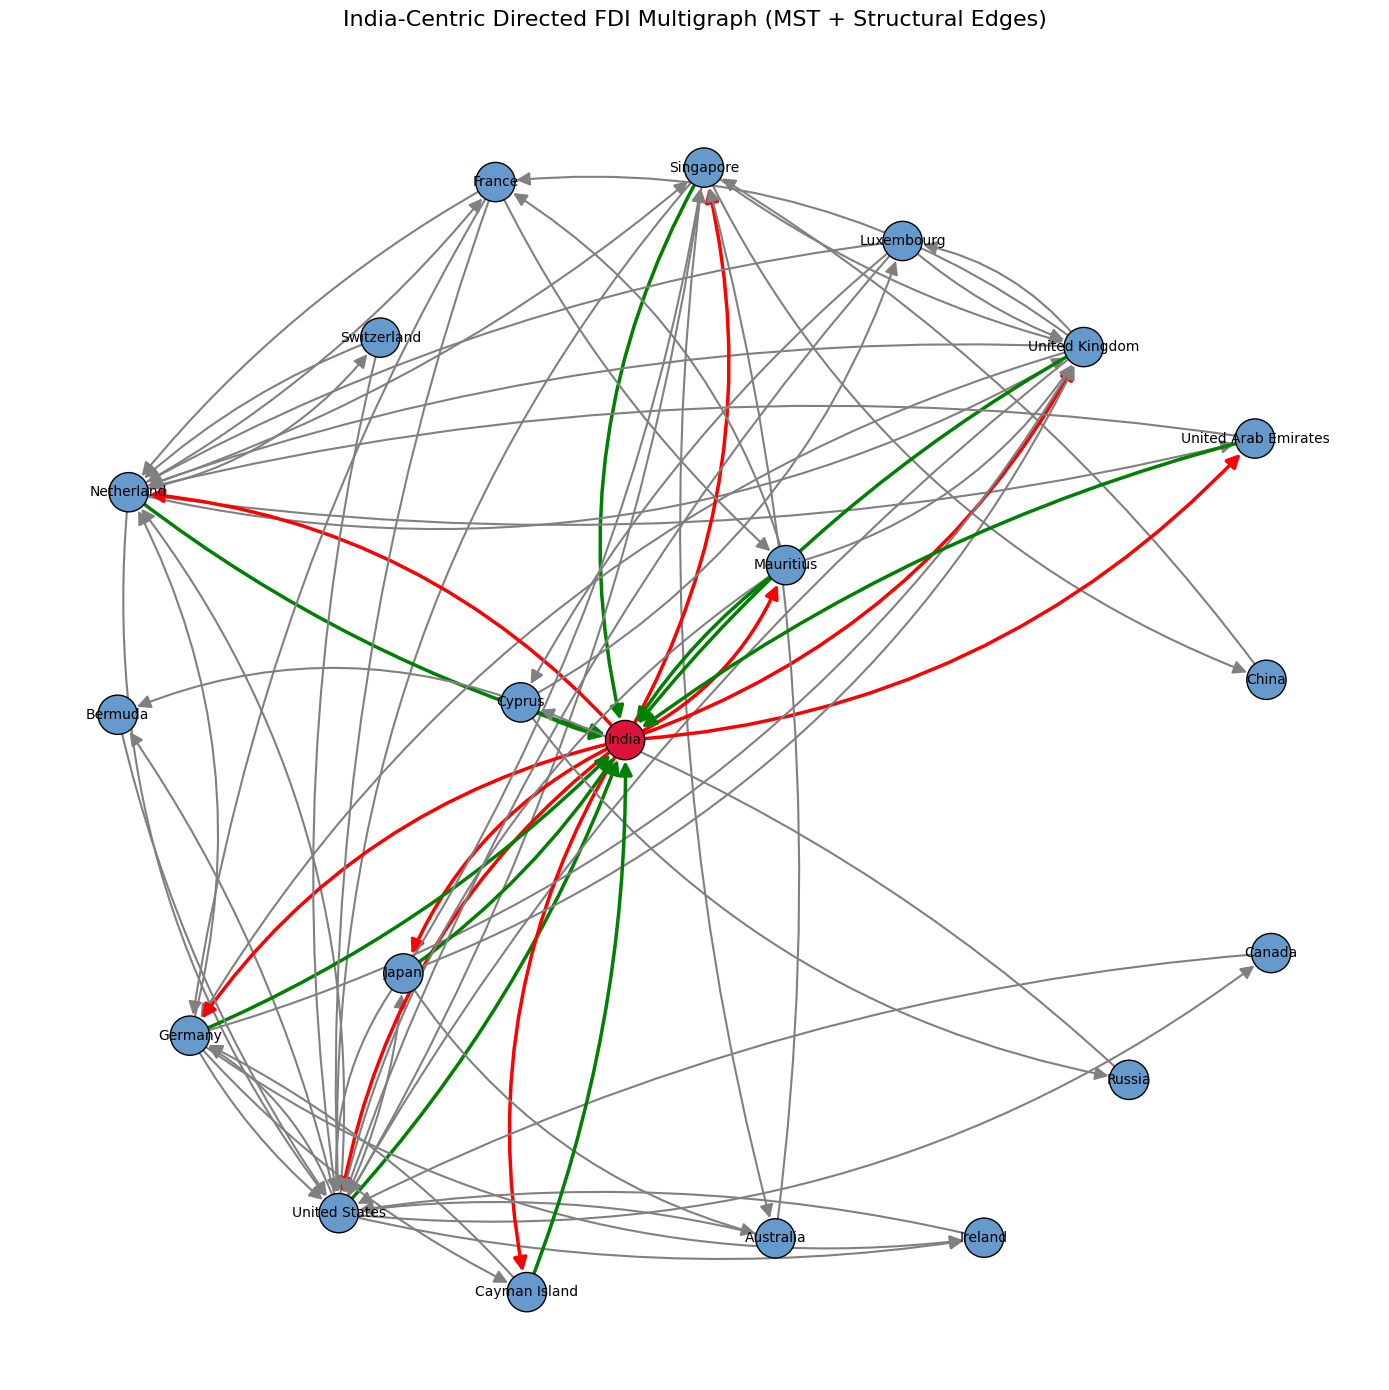

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

edges = []
for i in phi_percentile.index:
    for j in phi_percentile.columns:
        if i < j and phi_percentile.at[i, j] < np.inf:
            edges.append((i, j, phi_percentile.at[i, j]))  #weight = 1 / (|f_ij| + |f_ji|)

#Create MST from phi_percentile
G_full = nx.Graph()
G_full.add_weighted_edges_from(edges)
mst_edges = list(nx.minimum_spanning_edges(G_full, algorithm="kruskal", data=True))

#Force India → Top 10 edges (hub)
forced_edges = set()
for country in top_10:
    if country in phi_percentile.index:
        w = phi_percentile.at['India', country]
        if w < np.inf:
            forced_edges.add(('India', country, w))

#Force Top 10 → Top 3 edges
for parent, partners in top_3_partners.items():
    for child in partners:
        if parent in phi_percentile.index and child in phi_percentile.columns:
            w = phi_percentile.at[parent, child]
            if w < np.inf:
                forced_edges.add((parent, child, w))

#Build final graph with MST + forced edges
G_final = nx.DiGraph()
for u, v, d in mst_edges:
    G_final.add_edge(u, v, weight=d['weight'])
    G_final.add_edge(v, u, weight=d['weight'])

for u, v, w in forced_edges:
    G_final.add_edge(u, v, weight=w)

for u in top_10:
    if (u, 'India') not in G_final.edges():
        fij = f_ij.get((u, 'India'), 0)
        if fij > 0:
            total = fij + f_ij.get(('India', u), 0)
            if total > 0:
                G_final.add_edge(u, 'India', weight=1 / total)
k = 10
existing = {(u, v) for u, v in G_final.edges()}
extra_edges = []
for i, j, w in sorted(edges, key=lambda x: x[2]):  #(low φ = strong tie)
    if (i, j) not in existing and (j, i) not in existing:
        extra_edges.append((i, j, w))
    if len(extra_edges) >= k:
        break

for u, v, w in extra_edges:
    G_final.add_edge(u, v, weight=w)
pos = nx.spring_layout(G_final, seed=42)

plt.figure(figsize=(14, 14))
ax = plt.gca()
ax.set_title("India-Centric Directed FDI Multigraph (MST + Structural Edges)", fontsize=16, pad=20)

node_colors = ['crimson' if n == 'India' else '#6699CC' for n in G_final.nodes()]
nx.draw_networkx_nodes(G_final, pos, node_color=node_colors, node_size=800, edgecolors='black')
nx.draw_networkx_labels(G_final, pos, font_size=10)

for u, v in G_final.edges():
    weight = G_final[u][v]['weight']
    color = 'green' if v == 'India' else 'red' if u == 'India' else 'gray'
    width = 2.5 if color in ['green', 'red'] else 1.5
    style = 'arc3,rad=0.2' if (u, v, G_final[u][v]['weight']) in forced_edges else 'arc3,rad=0.1'

    nx.draw_networkx_edges(
        G_final, pos,
        edgelist=[(u, v)],
        arrowstyle='-|>',
        connectionstyle=style,
        edge_color=color,
        min_source_margin=10,
        min_target_margin=15,
        arrowsize=20,
        width=width,
        ax=ax
    )

plt.axis('off')
plt.tight_layout()
plt.savefig("india_fdi_hub_enforced_network.pdf", format='pdf', dpi=300)

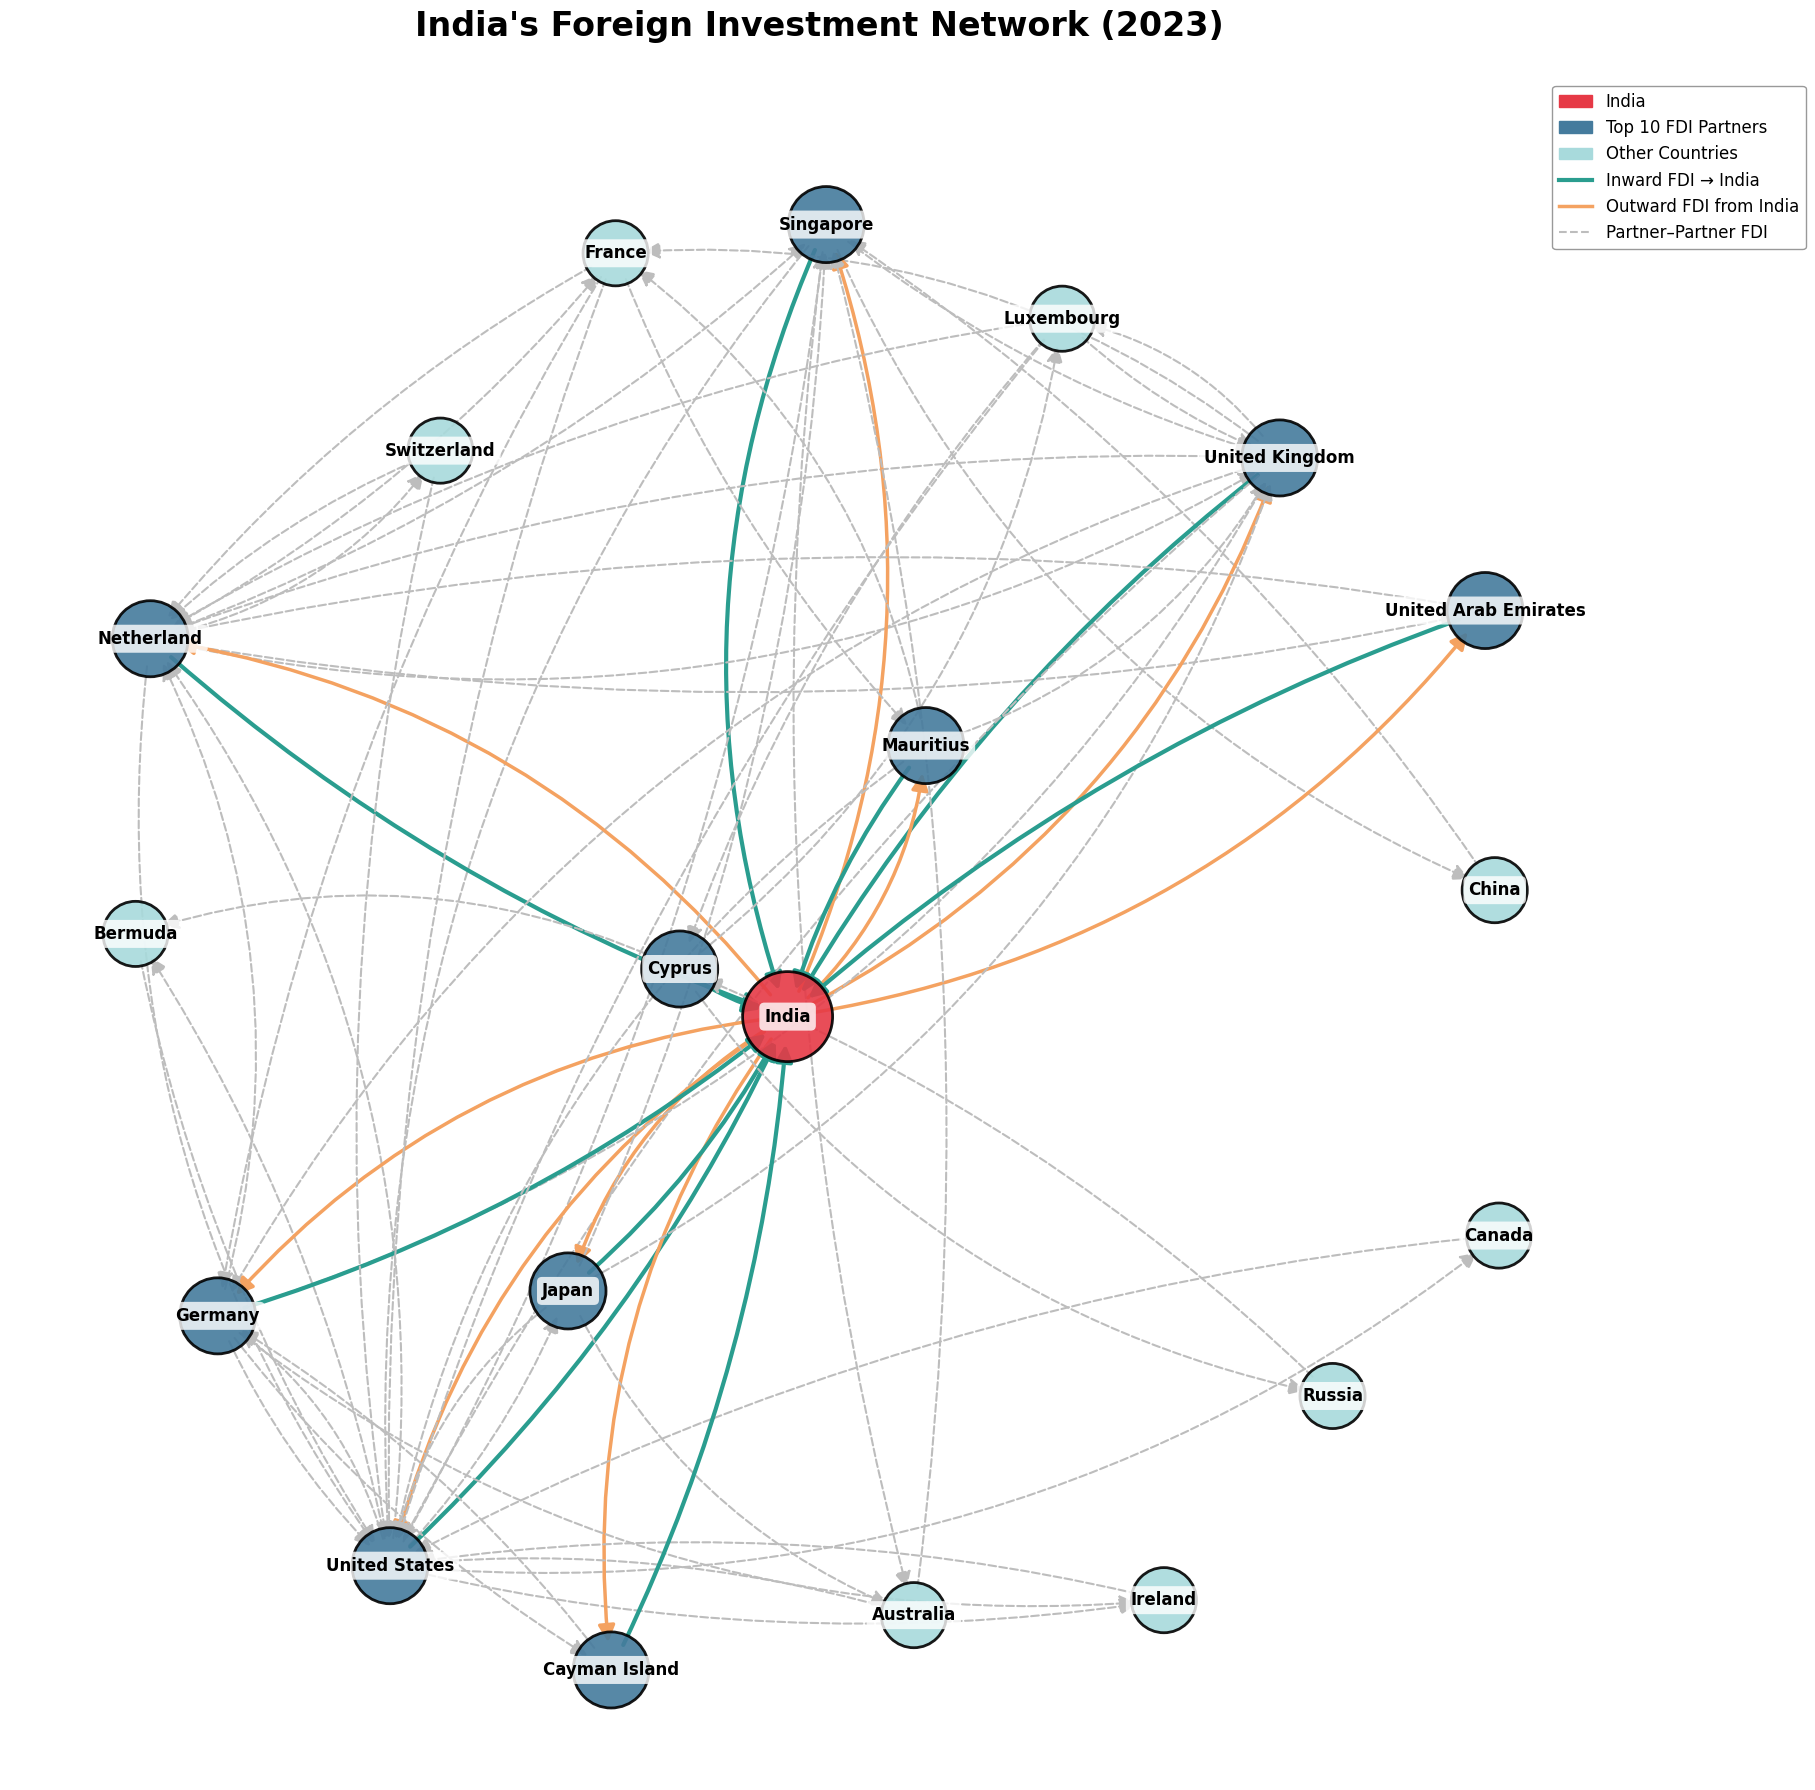

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
from collections import defaultdict

# Build graph edges
edges = []
for i in phi_percentile.index:
    for j in phi_percentile.columns:
        if i < j and phi_percentile.at[i, j] < np.inf:
            edges.append((i, j, phi_percentile.at[i, j]))

G_full = nx.Graph()
G_full.add_weighted_edges_from(edges)
mst_edges = list(nx.minimum_spanning_edges(G_full, algorithm="kruskal", data=True))

# Forced important edges
forced_edges = set()
for country in top_10:
    if country in phi_percentile.index:
        w = phi_percentile.at['India', country]
        if w < np.inf:
            forced_edges.add(('India', country, w))

for parent, partners in top_3_partners.items():
    for child in partners:
        if parent in phi_percentile.index and child in phi_percentile.columns:
            w = phi_percentile.at[parent, child]
            if w < np.inf:
                forced_edges.add((parent, child, w))

G_final = nx.DiGraph()
for u, v, d in mst_edges:
    G_final.add_edge(u, v, weight=d['weight'])
    G_final.add_edge(v, u, weight=d['weight'])

for u, v, w in forced_edges:
    G_final.add_edge(u, v, weight=w)

# Fill missing top-10 to India edges if needed
for u in top_10:
    if (u, 'India') not in G_final.edges():
        fij = f_ij.get((u, 'India'), 0)
        if fij > 0:
            total = fij + f_ij.get(('India', u), 0)
            if total > 0:
                G_final.add_edge(u, 'India', weight=1 / total)

# Add k strongest extra edges not already in the graph
k = 10
existing = {(u, v) for u, v in G_final.edges()}
extra_edges = []
for i, j, w in sorted(edges, key=lambda x: x[2]):
    if (i, j) not in existing and (j, i) not in existing:
        extra_edges.append((i, j, w))
    if len(extra_edges) >= k:
        break

for u, v, w in extra_edges:
    G_final.add_edge(u, v, weight=w)

# Start plotting
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G_final, seed=42, k=0.2)

def get_node_size(name):
    if name == 'India':
        return 4200
    elif name in top_10:
        return 3000
    else:
        return 2200

node_sizes = [get_node_size(n) for n in G_final.nodes()]
node_colors = ['#E63946' if n == 'India' else '#457B9D' if n in top_10 else '#A8DADC' for n in G_final.nodes()]

nx.draw_networkx_nodes(
    G_final, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors='black',
    linewidths=2,
    alpha=0.9
)

# Add labels to nodes
for node, (x, y) in pos.items():
    plt.text(x, y, node,
             fontsize=12,
             fontweight='bold',
             ha='center', va='center',
             bbox=dict(
                 facecolor='white',
                 edgecolor='none',
                 alpha=0.8,
                 boxstyle='round,pad=0.3'
             ))

# Draw edges with styles
for u, v in G_final.edges():
    if v == 'India':
        color = '#2A9D8F'  # Inward FDI
        width = 3.0
        style = 'solid'
    elif u == 'India':
        color = '#F4A261'  # Outward FDI
        width = 2.5
        style = 'solid'
    else:
        color = '#BDBDBD'  # Partner–Partner
        width = 1.5
        style = 'dashed'

    connection_style = 'arc3,rad=0.2' if (u, v, G_final[u][v]['weight']) in forced_edges else 'arc3,rad=0.1'

    nx.draw_networkx_edges(
        G_final, pos,
        edgelist=[(u, v)],
        edge_color=color,
        width=width,
        style=style,
        arrowsize=25,
        arrowstyle='-|>',
        connectionstyle=connection_style,
        min_source_margin=20,
        min_target_margin=20
    )

# Add proper legend
legend_elements = [
    mpatches.Patch(color='#E63946', label='India'),
    mpatches.Patch(color='#457B9D', label='Top 10 FDI Partners'),
    mpatches.Patch(color='#A8DADC', label='Other Countries'),
    Line2D([0], [0], color='#2A9D8F', lw=3, label='Inward FDI → India'),
    Line2D([0], [0], color='#F4A261', lw=2.5, label='Outward FDI from India'),
    Line2D([0], [0], color='#BDBDBD', lw=1.5, linestyle='--', label='Partner–Partner FDI')
]

plt.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.115, 1.0),
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='gray'
)

plt.title("India's Foreign Investment Network (2023)", fontsize=24, fontweight='bold', pad=30)
plt.axis('off')
plt.tight_layout()

plt.savefig("india_fdi_network_enhanced.pdf", format='pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


##Network Visualization: Design Rationale

### **Color Coding Strategy**
| **Color**       | **Nodes**          | **Analytical Purpose**                                                                 | **Data Basis**                              |
|-----------------|--------------------|--------------------------------------------------------------------------------------|--------------------------------------------|
| <span style="color:#DC143C">● Crimson</span> | India              | Highlights the focal point of all FDI relationships                                  | Fixed centrality in network analysis       |
| <span style="color:#6699CC">● Steel Blue</span> | Top 10 Partners   | Identifies India's most economically significant relationships                       | DPIIT-reported FDI volumes (>5% of total)  |
| <span style="color:#999999">● Light Gray</span> | Other Countries   | Provides geographical/economic context without visual dominance                      | Flows <2% of total FDI                     |

### **Size Hierarchy Logic**
1. **India (Largest)**  
   - Anchors the network topology  
   - Establishes visual reference scale  

2. **Top 10 Partners (Medium)**  
   - Size ∝ `log(FDI_flow)` to prevent distortion  
   - Maintains readability while showing relative importance  

3. **Other Countries (Smallest)**  
   - Standardized minimum size ensures:  
     - Network completeness  
     - Edge connection visibility  

### **Analytical Value**
- **Hub Identification**: Immediate visual confirmation of India's centrality  
- **Flow Concentration**: Size disparity reveals dependency risks  
- **Regional Clustering**: Gray node groupings show emerging market connections  

In [ ]:
import networkx as nx
import pandas as pd
from google.colab import files

#Compute centrality metrics
degree_centrality = nx.degree_centrality(G_final)
closeness_centrality = nx.closeness_centrality(G_final)
betweenness_centrality = nx.betweenness_centrality(G_final)
eigenvector_centrality = nx.eigenvector_centrality(G_final, max_iter=500)

centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
})

centrality_df = centrality_df.round(4)

average_row = centrality_df.mean(numeric_only=True).to_frame().T
average_row.index = ['Average (All Countries)']
centrality_df_with_avg = pd.concat([centrality_df, average_row])

centrality_df_with_avg = centrality_df_with_avg.reset_index()
centrality_df_with_avg.rename(columns={'index': 'Country'}, inplace=True)

output_path = 'FDI_Centrality_Metrics.csv'
centrality_df_with_avg.to_csv(output_path, index=False)

files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Average Shortest Path Length
# Use largest strongly connected component if graph isn't fully strongly connected
if nx.is_strongly_connected(G_final):
    avg_path_length = nx.average_shortest_path_length(G_final)
else:
    largest_scc_nodes = max(nx.strongly_connected_components(G_final), key=len)
    subgraph = G_final.subgraph(largest_scc_nodes).copy()
    avg_path_length = nx.average_shortest_path_length(subgraph)

# Global Clustering Coefficient
# Convert to undirected for clustering calculation (clustering is undefined for directed)
clustering_coeff = nx.average_clustering(G_final.to_undirected())

# Network Density
network_density = nx.density(G_final)

print("Network Structure Metrics")
print(f"Average Path Length (within SCC): {avg_path_length:.3f}")
print(f"Global Clustering Coefficient:     {clustering_coeff:.3f}")
print(f"Network Density:                   {network_density:.3f}")

Network Structure Metrics
Average Path Length (within SCC): 2.292
Global Clustering Coefficient:     0.530
Network Density:                   0.197


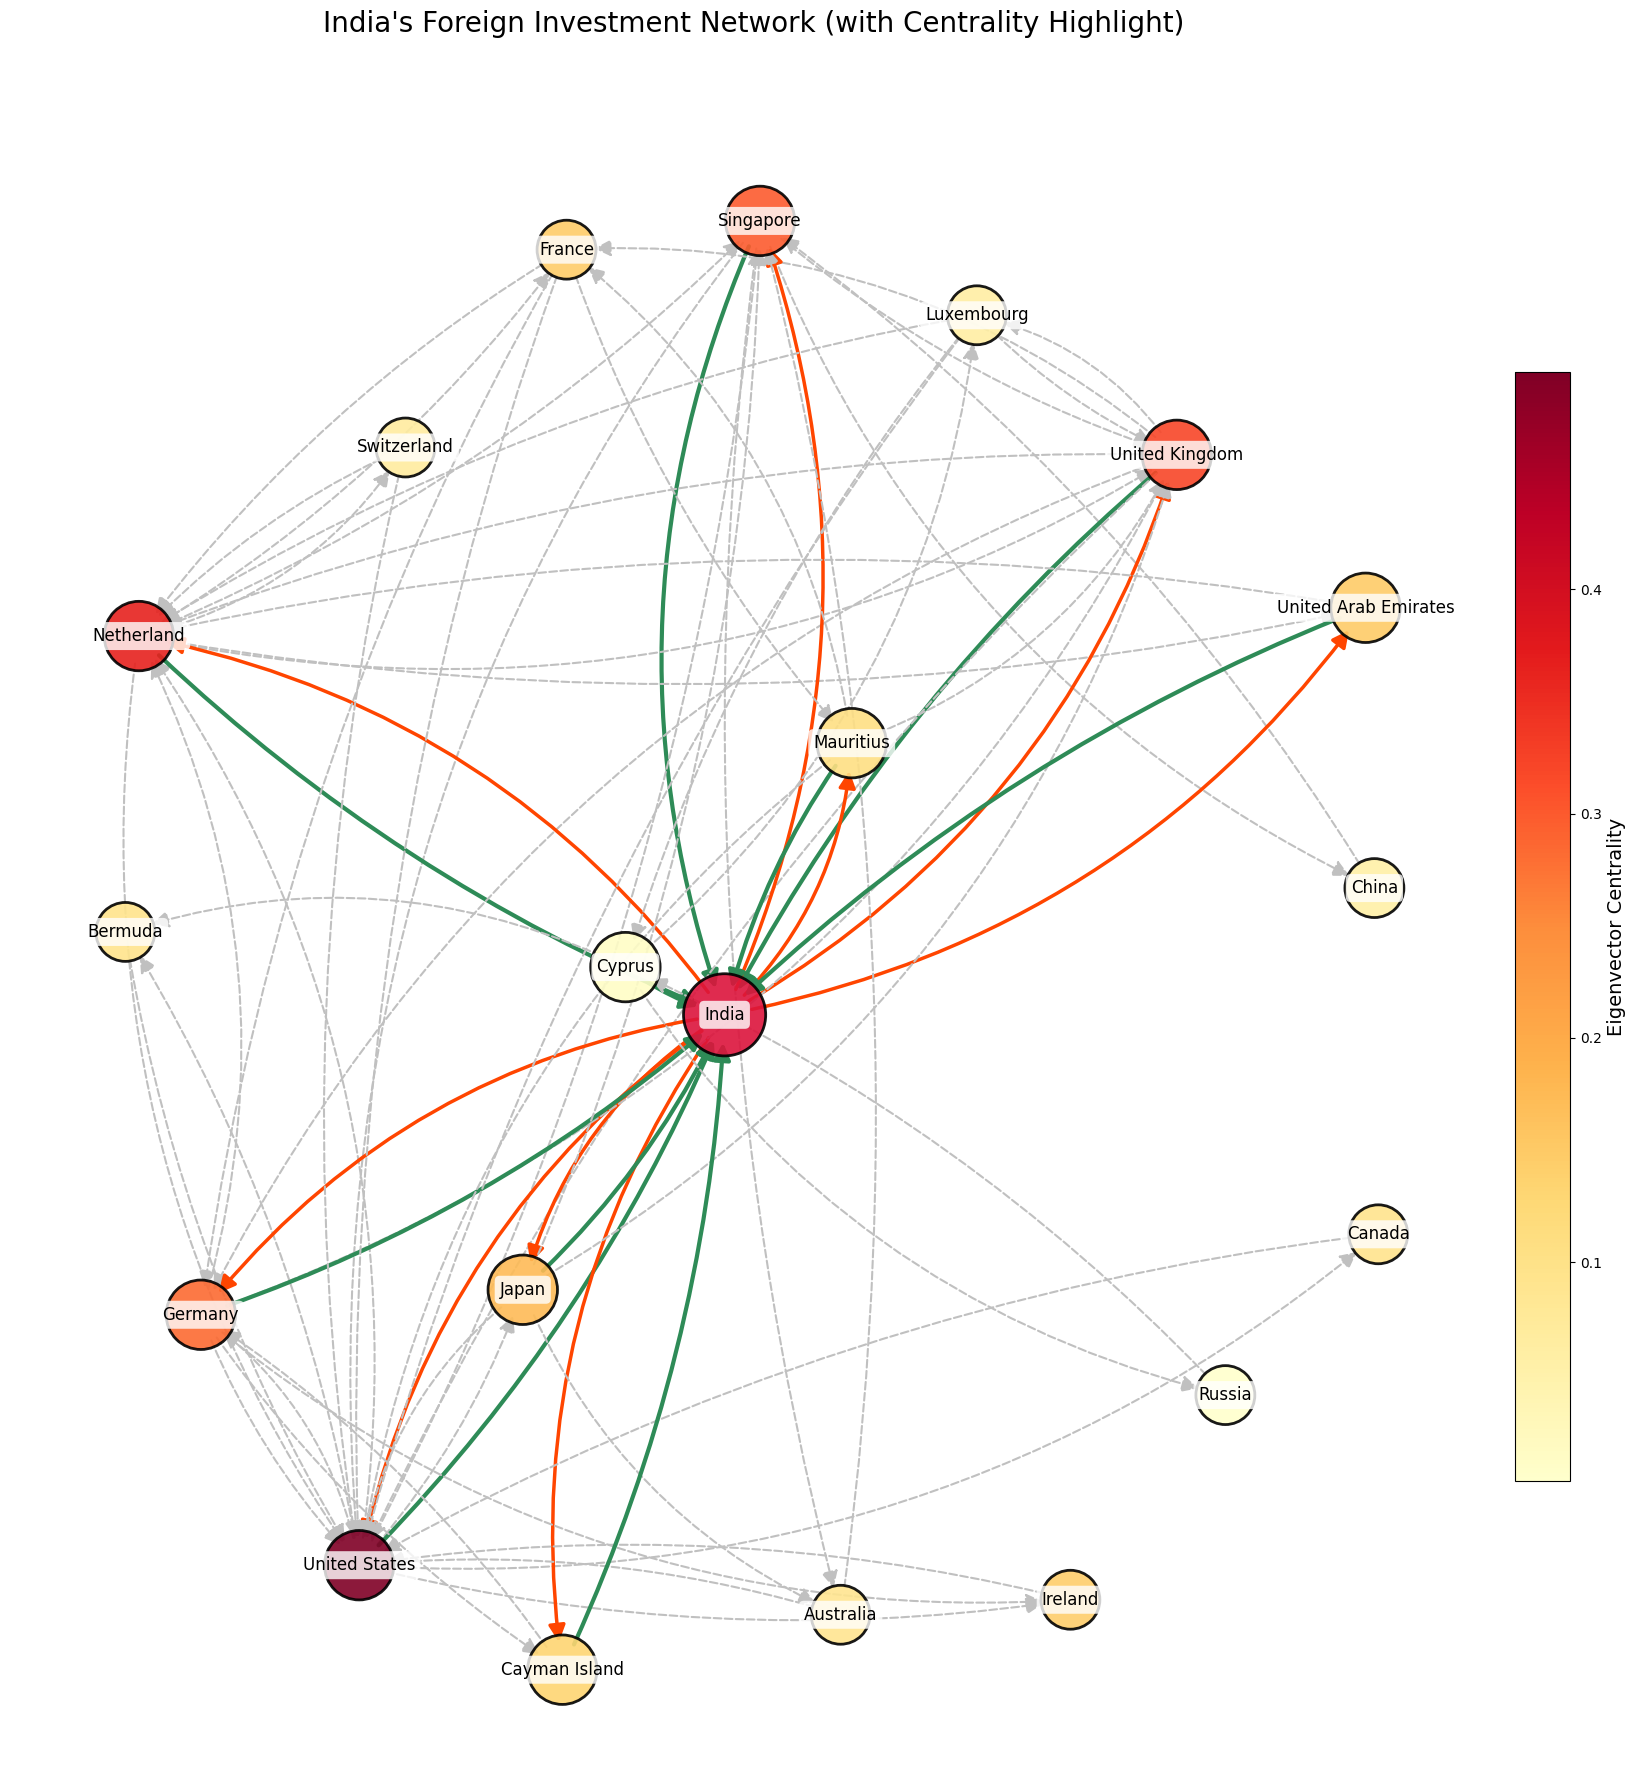

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from collections import defaultdict
from matplotlib import colormaps

edges = []
for i in phi_percentile.index:
    for j in phi_percentile.columns:
        if i < j and phi_percentile.at[i, j] < np.inf:
            edges.append((i, j, phi_percentile.at[i, j]))  # weight = 1/(|f_ij| + |f_ji|)
G_full = nx.Graph()
G_full.add_weighted_edges_from(edges)
mst_edges = list(nx.minimum_spanning_edges(G_full, algorithm="kruskal", data=True))

forced_edges = set()
for country in top_10:
    if country in phi_percentile.index:
        w = phi_percentile.at['India', country]
        if w < np.inf:
            forced_edges.add(('India', country, w))

for parent, partners in top_3_partners.items():
    for child in partners:
        if parent in phi_percentile.index and child in phi_percentile.columns:
            w = phi_percentile.at[parent, child]
            if w < np.inf:
                forced_edges.add((parent, child, w))

G_final = nx.DiGraph()
for u, v, d in mst_edges:
    G_final.add_edge(u, v, weight=d['weight'])
    G_final.add_edge(v, u, weight=d['weight'])

for u, v, w in forced_edges:
    G_final.add_edge(u, v, weight=w)

for u in top_10:
    if (u, 'India') not in G_final.edges():
        fij = f_ij.get((u, 'India'), 0)
        if fij > 0:
            total = fij + f_ij.get(('India', u), 0)
            if total > 0:
                G_final.add_edge(u, 'India', weight=1 / total)

# Add top k strongest extra links
k = 10
existing = {(u, v) for u, v in G_final.edges()}
extra_edges = []
for i, j, w in sorted(edges, key=lambda x: x[2]):
    if (i, j) not in existing and (j, i) not in existing:
        extra_edges.append((i, j, w))
    if len(extra_edges) >= k:
        break

for u, v, w in extra_edges:
    G_final.add_edge(u, v, weight=w)

eigenvector_centrality = nx.eigenvector_centrality(G_final, max_iter=500)

def get_node_size(name):
    if name == 'India':
        return 3500
    elif name in top_10:
        return 2500
    else:
        return 1800

node_sizes = [get_node_size(n) for n in G_final.nodes()]
norm = colors.Normalize(vmin=min(eigenvector_centrality.values()), vmax=max(eigenvector_centrality.values()))
cmap = colormaps.get_cmap('YlOrRd')
node_colors = [cmap(norm(eigenvector_centrality[n])) if n != 'India' else '#DC143C' for n in G_final.nodes()]

fig, ax = plt.subplots(figsize=(18, 18))
pos = nx.spring_layout(G_final, seed=42, k=0.2)

nx.draw_networkx_nodes(
    G_final, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors='black',
    linewidths=2,
    alpha=0.9,
    ax=ax
)

for node, (x, y) in pos.items():
    ax.text(x, y, node,
             fontsize=12,
             ha='center', va='center',
             bbox=dict(
                 facecolor='white',
                 edgecolor='none',
                 alpha=0.8,
                 boxstyle='round,pad=0.3'
             ))

for u, v in G_final.edges():
    if v == 'India':
        color = '#2E8B57'
        width = 3.0
        style = 'solid'
    elif u == 'India':
        color = '#FF4500'
        width = 2.5
        style = 'solid'
    else:
        color = '#C0C0C0'
        width = 1.5
        style = 'dashed'

    connection_style = 'arc3,rad=0.2' if (u, v, G_final[u][v]['weight']) in forced_edges else 'arc3,rad=0.1'

    nx.draw_networkx_edges(
        G_final, pos,
        edgelist=[(u, v)],
        edge_color=color,
        width=width,
        style=style,
        arrowsize=25,
        arrowstyle='-|>',
        connectionstyle=connection_style,
        min_source_margin=20,
        min_target_margin=20,
        ax=ax
    )

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.65, pad=0.01, ax=ax)
cbar.set_label("Eigenvector Centrality", fontsize=14)

ax.set_title("India's Foreign Investment Network (with Centrality Highlight)", fontsize=20, pad=30)
ax.axis('off')
plt.tight_layout()

plt.savefig(
    "india_fdi_network_with_centrality.pdf",
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)
plt.show()